# Our own version of the portfolio model

Currently the objective is:
$$
f(w) = w^\top \Sigma w - \mu^\top w,
$$
but this is highly unrealistic way to optimize modern portfolios. First of all note that in reality $w \in [0,1]$ which makes the problem convex and tractable. We need induce non-convexity. Indeed, one way is to restrict the weights to a discrete domain. This is still ok to solve for quite large portfolios though. I propose any (or all) of the following modifications and to try to encode them onto QAOA.

#### (a) Realistic utility function

Use instead of $\mu^\top w$ the "expanded" utility function 
$$
U(w) = \sum_{i=1}^n \mu_iw_i - \gamma \sum_{i=1}^n w_i \ln (w_i + \epsilon),
$$
where $\gamma$ is a penalization term for over concentration and $\epsilon$ is a regularization term. Taylor truncate (e.g. 2nd order?) the log or use Chebysev basis and truncate instead. Pic a small value for $\epsilon$ e.g. 0.001. 

#### (b) Potential loss

Enhance the risk with a downside risk term able to focus on the potential loss of the exercise. That is, include a term 
$$
S(w) = \sum_{i=1}^n \sum_{j=1}^n w_iw_j \Sigma_{ij}^{-},
$$
where $\Sigma_{ij}^{-}$ is the covariance between returns $i$ and $j$ ONLY for negative deviations (and you can just artificially do that in some fake-ish data). 

#### (c) Transaction costs

That is a term 
$$
C(w) = \sum_{i=1}^b c_i |w_i - w_i^0|,
$$
where $w_i^0$ corresponds to an initial (pre-optimized) allocation weight for asset $i$. Now how do you encode this into QAOA? I am not sure. 


I guess, first one needds (for all the above, right?) encode $\{w_i\} \in [0,1]$, so for each weight use say $q=3$ qubits so that we have $2^q$ levels, so in this case $8$ levels divided by $n$. So, keep it reasonable with $n$ say also $8$? Then I guess, we may use a quantum register $\left|k_i\right\rangle$ for asset $i$, where $k_i$ is an integer, and $w_i=k_i /\left(2^q-1\right)$. We want to be able to express an operator $\hat{w}_i| k_i\rangle = w_i| k_i\rangle $. We need encode the absolute value and it's ok to use the quadratic approx $|x| \approx \sqrt{x^2}$ and somehow adjust classically? I am not 100% sure what it looks like in the end. Other approach would be piecewise linear encoding. For the transaction part, as said, use quadratic approximation and auxilliary qubits. Same for the exppnent, Taylor expand around the mean of $|w_i-wi^0|$ or such? I think all the above amount to some proper research paper to be fair. 


### The full 'Lagrangian'-like objective (the Hamiltonian we need encode) as a QUBO is

$$
f(w;p)  = w^T\Sigma w + \lambda S(w) - \beta U(w) + \delta C(w),
$$
with penalties $p=\{\lambda, \beta, \gamma\} >0$ and I believe we dont want them to vanish because we then go to the simplest problem ever, therefore the problem I believe we need solve is 
$$
\min_w \, \max_p \quad f(w;p)
$$
and given how hard it is to encode within QAOA I think we should be ok to
1. encode it as QUBO to have it "quantum ready".
2. run it over classical hardware for a $n=8$ instance to provide some results.
3. find a smart way to claim that we had to combine quantum and classical given how difficult the problem is.

# Let's do it

## Import functions

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from pypfopt import expected_returns, risk_models
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import seaborn as sns

# Define functions etc

In [74]:
class PortfolioOptimizer:
    def __init__(self, w_prior, data, n_assets):
        self.n_assets = n_assets
        self.data = data
        self.returns = self.data.pct_change().dropna()
        self.mu = expected_returns.mean_historical_return(self.data).values
        self.sigma = risk_models.sample_cov(self.data).values
        self.w_prior = w_prior  # Equal weights as prior

        # Constraints and bounds
        self.constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]
        self.bounds = [(0, 1)] * self.n_assets  # Min 1% weight


    # Utility
    def _U(self, w, mu, gamma, epsilon) -> float:
        return np.sum(mu * w) - gamma * np.sum(w * np.log(w + epsilon))


    # Potential loss (semi-variance)
    def _S(self, w, sigma_minus) -> float:
        n = len(w)
        s = 0.0
        for i in range(n):
            for j in range(n):
                s += w[i] * w[j] * sigma_minus[i, j]
        return s


    # Transaction costs
    def _C(self, w, w0, c) -> float:
        return np.sum(c * np.abs(w - w0))


    # Objective function
    def objective_function(self, w, w0, sigma, cost, mu, gamma, epsilon, beta, delta, alpha, 
                          sigma_minus=None, include_semi_variance=False) -> float:
        variance = w.T @ sigma @ w
        utility = self._U(w, mu, gamma, epsilon)
        transaction_costs = self._C(w, w0, cost)

        # Do case with S later

        return alpha * variance - (1 - alpha) * beta * utility + delta * transaction_costs**alpha


    # Wrapper for optimization
    def _objective_wrapper(self, w, params):
        """
        Wrapper to use instance parameters in the objective function.

        It just means you can use a "param" dictionary as an argument 
        in optimiser.minimise
        """
        return self.objective_function(
            w,
            w0=self.w_prior,
            sigma=self.sigma,
            mu=self.mu,
            cost=params['cost'],
            gamma=params['gamma'],
            epsilon=params['epsilon'],
            beta=params['beta'],
            delta=params['delta'],
            alpha=params['alpha'],
            include_semi_variance=params['include_semi_variance']
        )


    def optimise(self, params, solver):
        """
        This is where the solver is used
        """
        result = minimize(
            self._objective_wrapper,
            self.w_prior,
            args=params, # wrapped parameters
            method=solver,
            bounds=self.bounds,
            constraints=self.constraints
        )
        if not result.success:
            raise ValueError(f"Optimization failed: {result.message}")
        return result.x, result.fun
    

    def compute_metrics(self, w_posterior):
        portfolio_return = np.sum(self.mu * w_posterior)
        portfolio_variance = w_posterior.T @ self.sigma @ w_posterior
        portfolio_sharpe = (portfolio_return - 0.04) / np.sqrt(portfolio_variance)

        return portfolio_return, portfolio_variance, portfolio_sharpe
    

    def display_metrics(self, pf_return, pf_variance, pf_sharpe):
        print(f"Expected Annual Return: {pf_return:.4f}")
        print(f"Portfolio Variance: {pf_variance:.6f}")
        print(f"Sharpe Ratio: {pf_sharpe:.4f}\n")


    # add noise to the weights
    def noisify_weights(self, w_posterior, std=0.05):
        np.random.seed(42)
        noise = np.random.normal(0, std, self.n_assets)  # Gaussian noise
        w_posterior_noisy = w_posterior + noise
        # Normalize to sum to 1 and clip to bounds
        w_posterior_noisy = np.clip(w_posterior_noisy, 0.01, 1)
        w_posterior_noisy /= w_posterior_noisy.sum()  # Ensure sum = 1
        return w_posterior_noisy
    

    # minimum variance portfolio objective for baseline
    def mvp_objective(self, w, sigma):
        return w.T @ sigma @ w
    
    # mvp solver (needs a different objective fn so had to rewrite it)
    def optimise_mvp(self, solver):
        bounds_mvp = [(0, 1)] * self.n_assets

        result = minimize(
            self.mvp_objective,
            self.w_prior,
            args=(self.sigma,),
            method=solver,
            bounds=bounds_mvp,
            constraints=self.constraints
        )
        if not result.success:
            raise ValueError(f"Optimization failed: {result.message}")
        return result.x, result.fun
    

    def display_charts(self, companies, save_path="graphs/weight_distributions.png", *args, **kwargs):
        """
        Display bar charts for weight distributions using Seaborn and a consistent color palette.

        Args:
            companies (list): List of company names.
            *args: Positional arguments (not used in this case).
            **kwargs: Keyword arguments specifying weight distributions and settings.
                    Each key is the label, and the value can be a tuple with:
                    - weights (list)
                    - title (str) [optional]
        """
        # Define the color palette for the distributions
        color_palette = ['#000000', '#D92027', '#666666', '#808080', '#999999', '#B0B0B0', '#C0C0C0', '#D3D3D3']

        # Extract weight distributions from kwargs
        distributions = {}
        for idx, (key, value) in enumerate(kwargs.items()):
            if isinstance(value, tuple):  # Allow (weights, title) tuples
                distributions[key] = {
                    'weights': value[0],
                    'color': color_palette[idx % len(color_palette)],  # Cycle through palette
                    'title': value[1] if len(value) > 1 else f"{key.capitalize()} Weight Allocation"
                }
            else:  # Assume value is weights, assign default title
                distributions[key] = {
                    'weights': value,
                    'color': color_palette[idx % len(color_palette)],  # Cycle through palette
                    'title': f"{key.capitalize()} Weight Allocation"
                }

        # Number of charts is the number of distributions provided
        num_charts = len(distributions)
        if num_charts == 0:
            raise ValueError("No weight distributions provided in kwargs")

        # Dynamically create subplots
        fig, axes = plt.subplots(1, num_charts, figsize=(5 * num_charts, 5), sharey=True)
        
        # Handle single chart case (axes is not an array)
        if num_charts == 1:
            axes = [axes]
        
        # Use Seaborn theme for consistent styling
        sns.set_theme(style="whitegrid")  # Consistent theme as in the example

        # Plot each distribution
        for ax, (label, dist) in zip(axes, distributions.items()):
            weights = dist['weights']
            color = dist.get('color', '#000000')  # Use provided or default color
            title = dist.get('title', f"{label.capitalize()} Weight Allocation")  # Use provided or default title
            
            # Ensure weights match number of companies
            if len(weights) != len(companies):
                raise ValueError(f"Length of weights ({len(weights)}) for '{label}' does not match number of companies ({len(companies)})")
            
            # Use Seaborn's barplot for better styling
            sns.barplot(x=companies, y=weights, ax=ax, color=color)
            ax.set_title(title)
            ax.set_xlabel("Companies")
            ax.set_ylabel("Weight")
            ax.tick_params(axis='x', rotation=45)

        # Final adjustments
        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Graph saved to {save_path}")
            

        plt.show()


    def efficient_frontier(self, method, base_params, alpha_range=(0, 1), num_points=20):
            alpha_values = np.linspace(alpha_range[0], alpha_range[1], num_points)
            returns = []
            variances = []

            if method == "optimiser":
                for alpha in alpha_values:
                    params = base_params.copy()
                    params['alpha'] = alpha
                    w_opt, _ = self.optimise(params = params, solver = "SLSQP")
                    pf_return, pf_variance, _ = self.compute_metrics(w_opt)
                    returns.append(pf_return)
                    variances.append(pf_variance)

            # Plot the efficient frontier
            plt.figure(figsize=(10, 6))
            plt.plot(variances, returns, 'b-o', label='Efficient Frontier')
            plt.xlabel('Portfolio Variance')
            plt.ylabel('Expected Annual Return')
            plt.title('Efficient Frontier (Alpha Variation)')
            plt.legend()
            plt.grid(True)
            plt.show()


    def efficient_frontier_gammas(self, 
                                  method, 
                                  base_params, 
                                  alpha_range=(0, 1), 
                                  num_points=20,
                                  noisify = False,
                                  save_path="graphs/efficient_frontier_gammas.png",
                                  ) -> None:
        """
        Compute and plot the efficient frontier by varying alpha for multiple gamma values on the same figure.
        """
        alpha_values = np.linspace(alpha_range[0], alpha_range[1], num_points)
        gamma_values = [0, 0.5, 1, 2, 5, 10]  # Multiple gamma values to test
        frontiers = {}  # Store returns and variances for each gamma

        # Colors for different gamma values
        colors = ['b', 'g', 'r', 'c', 'm', 'k']

        if method == "optimiser":
            # Create a single figure for all frontiers
            plt.figure(figsize=(10, 6))
            
            # Actually ignore this and leave nosify = False
            if noisify:
                for gamma, color in zip(gamma_values, colors):
                    returns = []
                    variances = []
                    # Create a copy of base_params for this gamma
                    params = base_params.copy()
                    params['gamma'] = gamma  # Set the gamma value
                    
                    for alpha in alpha_values:
                        params['alpha'] = alpha
                        w_opt, _ = self.optimise(params=params, solver="SLSQP")
                        w_noisy = self.noisify_weights(w_opt)
                        pf_return, pf_variance, _ = self.compute_metrics(w_noisy)
                        returns.append(pf_return)
                        variances.append(pf_variance)

                    # Store results
                    frontiers[gamma] = (np.array(returns), np.array(variances))
                    
                    # Plot the frontier for this gamma on the same figure
                    plt.plot(variances, returns, f'{color}-', label=f'Gamma = {gamma}', alpha=0.7)

                # Customize the plot
                plt.xlabel('Portfolio Variance')
                plt.ylabel('Expected Annual Return')
                plt.title('Efficient Frontier (Alpha Variation) for Different Gamma Values and noisy weights')
                plt.legend()
                plt.grid(True)

                if save_path:
                    plt.savefig(save_path, dpi=300, bbox_inches='tight')
                    print(f"Graph saved to {save_path}")
            
                plt.show()
            else:
                for gamma, color in zip(gamma_values, colors):
                    returns = []
                    variances = []
                    # Create a copy of base_params for this gamma
                    params = base_params.copy()
                    params['gamma'] = gamma  # Set the gamma value
                    
                    for alpha in alpha_values:
                        params['alpha'] = alpha
                        w_opt, _ = self.optimise(params=params, solver="SLSQP")
                        pf_return, pf_variance, _ = self.compute_metrics(w_opt)
                        returns.append(pf_return)
                        variances.append(pf_variance)

                    # Store results
                    frontiers[gamma] = (np.array(returns), np.array(variances))
                    
                    # Plot the frontier for this gamma on the same figure
                    plt.plot(variances, returns, f'{color}-', label=f'Gamma = {gamma}', alpha=0.7)

                # Customize the plot
                plt.xlabel('Portfolio Variance')
                plt.ylabel('Expected Annual Return')
                plt.title('Efficient Frontier (Alpha Variation) for Different Gamma Values')
                plt.legend()
                plt.grid(True)

                if save_path:
                    plt.savefig(save_path, dpi=300, bbox_inches='tight')
                    print(f"Graph saved to {save_path}")
            
                plt.show()

    
    def efficient_frontier_noise_trends(self, base_params, alpha_range=(0, 1), num_points=20, save_path="graphs/efficient_frontier_noisy_trends.png"):
        """
        Compute and plot the efficient frontier by varying alpha for uniform, optimal, and noisy weights.
        """
        alpha_values = np.linspace(alpha_range[0], alpha_range[1], num_points)
        
        # Initialize dictionaries to store returns and variances for each weight type
        returns_dict = {'uniform': [], 'optimal': [], 'noisy': {}}
        variances_dict = {'uniform': [], 'optimal': [], 'noisy': {}}
        
        # Prepare data for Seaborn (long format for lineplot)
        plot_data = []
        
        
        # Noisy weights for different standard deviations
        noise_stds = [0, 0.05, 0.1, 1.0, 2.0, 5.0]
        # Gray shades for noisy weights (darker to lighter for increasing std)
        noisy_colors = ['#666666', '#808080', '#999999', '#B0B0B0', '#C0C0C0', '#D3D3D3']
        
        for std, color in zip(noise_stds, noisy_colors):
            returns_dict['noisy'][std] = []
            variances_dict['noisy'][std] = []
            for alpha in alpha_values:
                params = base_params.copy()
                params['alpha'] = alpha
                w_opt, _ = self.optimise(params=params, solver="SLSQP")
                w_noisy = self.noisify_weights(w_opt, std)
                pf_return, pf_variance, _ = self.compute_metrics(w_noisy)
                returns_dict['noisy'][std].append(pf_return)
                variances_dict['noisy'][std].append(pf_variance)
                plot_data.append({'Variance': pf_variance, 'Return': pf_return, 'Type': f'Noisy Weights (σ={std})'})
        
        # Optimal weights
        for alpha in alpha_values:
            params = base_params.copy()
            params['alpha'] = alpha
            w_opt, _ = self.optimise(params=params, solver="SLSQP")
            pf_return, pf_variance, _ = self.compute_metrics(w_opt)
            returns_dict['optimal'].append(pf_return)
            variances_dict['optimal'].append(pf_variance)
            plot_data.append({'Variance': pf_variance, 'Return': pf_return, 'Type': 'Optimal Weights'})

        # Convert to DataFrame for Seaborn
        df = pd.DataFrame(plot_data)
        
        # Create the plot using Seaborn
        plt.figure(figsize=(10, 6))
        # Colour palette
        palette = {
            'Uniform Weights': '#000000',  # Black for uniform weights
            'Optimal Weights': '#D92027',  # Red for optimal weights
        }
        # Add noisy weights to palette (using gray shades)
        for std, color in zip(noise_stds, noisy_colors):
            palette[f'Noisy Weights (σ={std})'] = color

        # Use Seaborn lineplot
        sns.lineplot(data=df, x='Variance', y='Return', hue='Type', style='Type', 
                    palette=palette, markers='o', legend='brief', 
                    linewidth=1, markeredgewidth=0)  # Set markeredgewidth=0 to remove outline
        
        # Customize the plot
        plt.xlabel('Portfolio Variance')
        plt.ylabel('Expected Annual Return')
        plt.title('Efficient Frontier (Alpha Variation) with Noise Trends')
        plt.grid(True)

        # Save the plot if save_path is provided
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Graph saved to {save_path}")

        plt.show()


    def plot_diff_gamma(self, params):
        """
        Plot portfolio return, variance, and Sharpe ratio for different gamma values using Seaborn.
        
        Args:
            params (dict): Base parameters for optimization, updated with different gamma values.
        """
        # Define gamma values
        gammas = [0, 0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
        
        # Lists to store metrics
        returns = []
        variances = []
        sharpes = []

        # Copy the base parameters to avoid modifying the input
        params_local = params.copy()

        # Optimize for each gamma value and compute metrics
        for gamma in gammas:
            params_local['gamma'] = gamma

            try:
                w_posterior_local, _ = self.optimise(params=params_local, solver="SLSQP")
                local_return, local_variance, local_sharpe = self.compute_metrics(w_posterior_local)
                returns.append(local_return)
                variances.append(local_variance)
                sharpes.append(local_sharpe)
            except ValueError as e:
                print(f"Optimization failed for gamma={gamma}: {e}")
                returns.append(np.nan)
                variances.append(np.nan)
                sharpes.append(np.nan)

        # Prepare data for Seaborn in long format
        data = pd.DataFrame({
            'Gamma': gammas * 3,  # Repeat for each metric
            'Value': returns + variances + sharpes,
            'Metric': ['Return'] * len(gammas) + ['Variance'] * len(gammas) + ['Sharpe'] * len(gammas)
        })

        # Define the custom color palette (using the first three colors for clarity)
        color_palette = ['#000000', '#D92027', '#666666', '#808080', '#999999', '#B0B0B0', '#C0C0C0', '#D3D3D3']
        palette = {
            'Return': color_palette[0],  # Black
            'Variance': color_palette[1],  # Red
            'Sharpe': color_palette[2]  # Dark gray
        }

        # Set Seaborn theme for consistent styling
        sns.set_theme(style="whitegrid")  # Clean background with grid

        # Create a single figure with three subplots using Seaborn
        plt.figure(figsize=(15, 5))

        # Plot 1: Portfolio Return vs Gamma
        plt.subplot(1, 3, 1)
        sns.lineplot(data=data[data['Metric'] == 'Return'], x='Gamma', y='Value', color=palette['Return'], 
                    marker='o', label='Portfolio Return')
        plt.xlabel('Gamma')
        plt.ylabel('Expected Annual Return')
        plt.title('Portfolio Return vs Gamma')
        plt.grid(True)
        plt.legend()

        # Plot 2: Portfolio Variance vs Gamma
        plt.subplot(1, 3, 2)
        sns.lineplot(data=data[data['Metric'] == 'Variance'], x='Gamma', y='Value', color=palette['Variance'], 
                    marker='o', label='Portfolio Variance')
        plt.xlabel('Gamma')
        plt.ylabel('Portfolio Variance')
        plt.title('Portfolio Variance vs Gamma')
        plt.grid(True)
        plt.legend()

        # Plot 3: Portfolio Sharpe Ratio vs Gamma
        plt.subplot(1, 3, 3)
        sns.lineplot(data=data[data['Metric'] == 'Sharpe'], x='Gamma', y='Value', color=palette['Sharpe'], 
                    marker='o', label='Sharpe Ratio')
        plt.xlabel('Gamma')
        plt.ylabel('Sharpe Ratio')
        plt.title('Sharpe Ratio vs Gamma')
        plt.grid(True)
        plt.legend()

        # Adjust layout to prevent overlap
        plt.tight_layout()
        plt.show()


    def plot_diff_alpha(self, params):
        """
        Plot portfolio return, variance, and Sharpe ratio for different gamma values using Seaborn.
        
        Args:
            params (dict): Base parameters for optimization, updated with different gamma values.
        """
        # Define gamma values
        alpha_values = np.linspace(0, 1, 10)
        
        # Lists to store metrics
        returns = []
        variances = []
        sharpes = []

        # Copy the base parameters to avoid modifying the input
        params_local = params.copy()

        # Optimize for each gamma value and compute metrics
        for alpha in alpha_values:
            params_local['alpha'] = alpha

            try:
                w_posterior_local, _ = self.optimise(params=params_local, solver="SLSQP")
                local_return, local_variance, local_sharpe = self.compute_metrics(w_posterior_local)
                returns.append(local_return)
                variances.append(local_variance)
                sharpes.append(local_sharpe)
            except ValueError as e:
                print(f"Optimization failed for alpha={alpha}: {e}")
                returns.append(np.nan)
                variances.append(np.nan)
                sharpes.append(np.nan)

        # Prepare data for Seaborn in long format
        data = pd.DataFrame({
            'Alpha': np.concatenate([alpha_values] * 3),  # Repeat for each metric
            'Value': returns + variances + sharpes,
            'Metric': ['Return'] * len(alpha_values) + ['Variance'] * len(alpha_values) + ['Sharpe'] * len(alpha_values)
        })

        # Define the custom color palette (using the first three colors for clarity)
        color_palette = ['#000000', '#D92027', '#666666', '#808080', '#999999', '#B0B0B0', '#C0C0C0', '#D3D3D3']
        palette = {
            'Return': color_palette[0],  # Black
            'Variance': color_palette[1],  # Red
            'Sharpe': color_palette[2]  # Dark gray
        }

        # Set Seaborn theme for consistent styling
        sns.set_theme(style="whitegrid")  # Clean background with grid

        # Create a single figure with three subplots using Seaborn
        plt.figure(figsize=(15, 5))

        # Plot 1: Portfolio Return vs Gamma
        plt.subplot(1, 3, 1)
        sns.lineplot(data=data[data['Metric'] == 'Return'], x='Alpha', y='Value', color=palette['Return'], 
                    marker='o', label='Portfolio Return')
        plt.xlabel('Alpha')
        plt.ylabel('Expected Annual Return')
        plt.title('Portfolio Return vs Alpha')
        plt.grid(True)
        plt.legend()

        # Plot 2: Portfolio Variance vs Gamma
        plt.subplot(1, 3, 2)
        sns.lineplot(data=data[data['Metric'] == 'Variance'], x='Alpha', y='Value', color=palette['Variance'], 
                    marker='o', label='Portfolio Variance')
        plt.xlabel('Alpha')
        plt.ylabel('Portfolio Variance')
        plt.title('Portfolio Variance vs Alpha')
        plt.grid(True)
        plt.legend()

        # Plot 3: Portfolio Sharpe Ratio vs Gamma
        plt.subplot(1, 3, 3)
        sns.lineplot(data=data[data['Metric'] == 'Sharpe'], x='Alpha', y='Value', color=palette['Sharpe'], 
                    marker='o', label='Sharpe Ratio')
        plt.xlabel('Alpha')
        plt.ylabel('Sharpe Ratio')
        plt.title('Sharpe Ratio vs Alpha')
        plt.grid(True)
        plt.legend()

        # Adjust layout to prevent overlap
        plt.tight_layout()
        plt.show()


    def plot_diff_beta(self, params):
        """
        Plot portfolio return, variance, and Sharpe ratio for different gamma values using Seaborn.
        
        Args:
            params (dict): Base parameters for optimization, updated with different gamma values.
        """
        # Define gamma values
        betas = [0, 0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
        
        # Lists to store metrics
        returns = []
        variances = []
        sharpes = []

        # Copy the base parameters to avoid modifying the input
        params_local = params.copy()

        # Optimize for each gamma value and compute metrics
        for beta in betas:
            params_local['beta'] = beta

            try:
                w_posterior_local, _ = self.optimise(params=params_local, solver="SLSQP")
                local_return, local_variance, local_sharpe = self.compute_metrics(w_posterior_local)
                returns.append(local_return)
                variances.append(local_variance)
                sharpes.append(local_sharpe)
            except ValueError as e:
                print(f"Optimization failed for beta={beta}: {e}")
                returns.append(np.nan)
                variances.append(np.nan)
                sharpes.append(np.nan)

        # Prepare data for Seaborn in long format
        data = pd.DataFrame({
            'Beta': betas * 3,  # Repeat for each metric
            'Value': returns + variances + sharpes,
            'Metric': ['Return'] * len(betas) + ['Variance'] * len(betas) + ['Sharpe'] * len(betas)
        })

        # Define the custom color palette (using the first three colors for clarity)
        color_palette = ['#000000', '#D92027', '#666666', '#808080', '#999999', '#B0B0B0', '#C0C0C0', '#D3D3D3']
        palette = {
            'Return': color_palette[0],  # Black
            'Variance': color_palette[1],  # Red
            'Sharpe': color_palette[2]  # Dark gray
        }

        # Set Seaborn theme for consistent styling
        sns.set_theme(style="whitegrid")  # Clean background with grid

        # Create a single figure with three subplots using Seaborn
        plt.figure(figsize=(15, 5))

        # Plot 1: Portfolio Return vs Gamma
        plt.subplot(1, 3, 1)
        sns.lineplot(data=data[data['Metric'] == 'Return'], x='Beta', y='Value', color=palette['Return'], 
                    marker='o', label='Portfolio Return')
        plt.xlabel('Beta')
        plt.ylabel('Expected Annual Return')
        plt.title('Portfolio Return vs Beta')
        plt.grid(True)
        plt.legend()

        # Plot 2: Portfolio Variance vs Gamma
        plt.subplot(1, 3, 2)
        sns.lineplot(data=data[data['Metric'] == 'Variance'], x='Beta', y='Value', color=palette['Variance'], 
                    marker='o', label='Portfolio Variance')
        plt.xlabel('Beta')
        plt.ylabel('Portfolio Variance')
        plt.title('Portfolio Variance vs Beta')
        plt.grid(True)
        plt.legend()

        # Plot 3: Portfolio Sharpe Ratio vs Gamma
        plt.subplot(1, 3, 3)
        sns.lineplot(data=data[data['Metric'] == 'Sharpe'], x='Beta', y='Value', color=palette['Sharpe'], 
                    marker='o', label='Sharpe Ratio')
        plt.xlabel('Beta')
        plt.ylabel('Sharpe Ratio')
        plt.title('Sharpe Ratio vs Beta')
        plt.grid(True)
        plt.legend()

        # Adjust layout to prevent overlap
        plt.tight_layout()
        plt.show()


    def benchmark_sp500_one_pf(self, weights, portfolio_data, sp500_data, save_path="graphs/sp500_benchmark_one.png"):
        # Ensure portfolio_data shape matches weights
        if portfolio_data.shape[1] != len(weights):
            raise ValueError(f"Portfolio data has {portfolio_data.shape[1]} stocks, but weights have length {len(weights)}")

        # Calculate daily returns
        portfolio_returns = portfolio_data.pct_change().dropna()
        sp500_returns = sp500_data.pct_change().dropna()

        # Calculate portfolio daily returns using weights
        weighted_portfolio_returns = portfolio_returns.dot(weights)

        # Create a DataFrame to hold both portfolio and S&P 500 returns
        returns_df = pd.DataFrame({
            'Portfolio': weighted_portfolio_returns,
            'S&P 500': sp500_returns
        })

        # Calculate cumulative returns
        cumulative_returns = (1 + returns_df).cumprod() - 1

        # Metrics
        mean_returns = returns_df.mean() * 252  # Annualized mean returns
        volatility = returns_df.std() * np.sqrt(252)  # Annualized volatility
        sharpe_ratio = mean_returns / volatility  # Sharpe ratio

        # Print metrics
        print("Performance Metrics:")
        print(f"Portfolio Cumulative Return: {cumulative_returns['Portfolio'].iloc[-1]:.2%}")
        print(f"S&P 500 Cumulative Return: {cumulative_returns['S&P 500'].iloc[-1]:.2%}")
        print(f"Portfolio Volatility: {volatility['Portfolio']:.2%}")
        print(f"S&P 500 Volatility: {volatility['S&P 500']:.2%}")
        print(f"Portfolio Sharpe Ratio: {sharpe_ratio['Portfolio']:.2f}")
        print(f"S&P 500 Sharpe Ratio: {sharpe_ratio['S&P 500']:.2f}")

        # Visualization
        plt.figure(figsize=(12, 6))
        plt.plot(cumulative_returns.index, cumulative_returns['Portfolio'], 
                label='Optimized Portfolio', color='#D92027', linewidth=2)  # Red
        plt.plot(cumulative_returns.index, cumulative_returns['S&P 500'], 
                label='S&P 500', color='#000000', linewidth=2, linestyle='--')  # Black
        plt.title('Cumulative Returns Comparison', fontsize=16)
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('Cumulative Return', fontsize=12)
        plt.legend(fontsize=10)
        plt.grid(alpha=0.3)
        plt.tight_layout()

        # Save the plot if save_path is provided
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Graph saved to {save_path}")

        plt.show()


    def benchmark_sp500_multi_pf(self, weights_list, portfolio_data, sp500_data, save_path="graphs/sp500_benchmark_all.png"):
        # Define the color palette
        color_palette = ['#000000', '#D92027', '#666666', '#808080', '#999999', '#B0B0B0', '#C0C0C0', '#D3D3D3']
        
        # Ensure weights_list has 3 sets of weights for the 3 portfolios
        if len(weights_list) != 3:
            raise ValueError(f"Expected 3 sets of weights, got {len(weights_list)}")
        
        # Ensure portfolio_data shape matches each set of weights
        for i, weights in enumerate(weights_list):
            if portfolio_data.shape[1] != len(weights):
                raise ValueError(f"Portfolio data has {portfolio_data.shape[1]} stocks, but weights[{i}] has length {len(weights)}")

        # Calculate daily returns
        portfolio_returns = portfolio_data.pct_change().dropna()
        sp500_returns = sp500_data.pct_change().dropna()

        # Calculate portfolio daily returns using weights for each portfolio
        optimized_portfolio_returns = portfolio_returns.dot(weights_list[0])  # Optimized portfolio
        portfolio2_returns = portfolio_returns.dot(weights_list[1])          # Portfolio 2
        portfolio3_returns = portfolio_returns.dot(weights_list[2])          # Portfolio 3

        # Create a DataFrame to hold all portfolio and S&P 500 returns
        returns_df = pd.DataFrame({
            'Optimized Portfolio': optimized_portfolio_returns,
            'Equal-weights Portfolio': portfolio2_returns,
            'Randomized Portfolio': portfolio3_returns,
            'S&P 500': sp500_returns
        })

        # Calculate cumulative returns
        cumulative_returns = (1 + returns_df).cumprod() - 1  # Using cumprod for compounding returns

        # Metrics
        mean_returns = returns_df.mean() * len(portfolio_returns)  # Annualized mean returns
        volatility = returns_df.std() * np.sqrt(len(portfolio_returns))  # Annualized volatility
        sharpe_ratio = mean_returns / volatility  # Sharpe ratio

        # Print metrics
        print("Performance Metrics:")
        for portfolio in returns_df.columns:
            print(f"{portfolio} Cumulative Return: {cumulative_returns[portfolio].iloc[-1]:.2%}")
            print(f"{portfolio} Volatility: {volatility[portfolio]:.2%}")
            print(f"{portfolio} Sharpe Ratio: {sharpe_ratio[portfolio]:.2f}")
            print("---")

        # Visualization
        plt.figure(figsize=(12, 6))
        plt.plot(cumulative_returns.index, cumulative_returns['Optimized Portfolio'], 
                label='Optimized Portfolio', color=color_palette[1], linewidth=2)  # Red
        plt.plot(cumulative_returns.index, cumulative_returns['Equal-weights Portfolio'], 
                label='Equal-weights Portfolio', color=color_palette[2], linewidth=2)          # Dark gray
        plt.plot(cumulative_returns.index, cumulative_returns['Randomized Portfolio'], 
                label='Randomized Portfolio', color=color_palette[3], linewidth=2)          # Medium gray
        plt.plot(cumulative_returns.index, cumulative_returns['S&P 500'], 
                label='S&P 500', color=color_palette[0], linewidth=2, linestyle='--')  # Black
        plt.title('Cumulative Returns Comparison', fontsize=16)
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('Cumulative Return', fontsize=12)
        plt.legend(fontsize=10)
        plt.grid(alpha=0.3)
        plt.tight_layout()

        # Save the plot if save_path is provided
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Graph saved to {save_path}")
            
        plt.show()


## Import the data

In [3]:
start_date = '2024-01-01'
end_date = '2024-12-31'

# Fetch data
us_market_stocks = [
    'MSFT',  # Microsoft - Technology
    'AAPL',  # Apple - Technology
    'NVDA',  # NVIDIA - Technology/Semiconductors
    'META',  # Meta Platforms (Facebook) - Communication Services
    'TSLA',  # Tesla - Consumer Discretionary
    'JNJ',   # Johnson & Johnson - Healthcare
    'CVX',   # Chevron - Energy
    'WMT',   # Walmart - Consumer Staples
    'DIS',   # Disney - Communication Services
    'XOM'    # Exxon Mobil - Energy
]

us_data = yf.download(us_market_stocks, start=start_date, end=end_date, progress=True, threads=False)
sp500_data = yf.download(['^GSPC'], start=start_date, end=end_date, progress=True, threads=False)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


## Create optimiser

In [75]:
n_assets = len(us_market_stocks)
w_prior = np.ones(n_assets) / n_assets

optimiser = PortfolioOptimizer(w_prior = w_prior, data = us_data['Close'], n_assets = n_assets)

## Alpha, beta, gamma

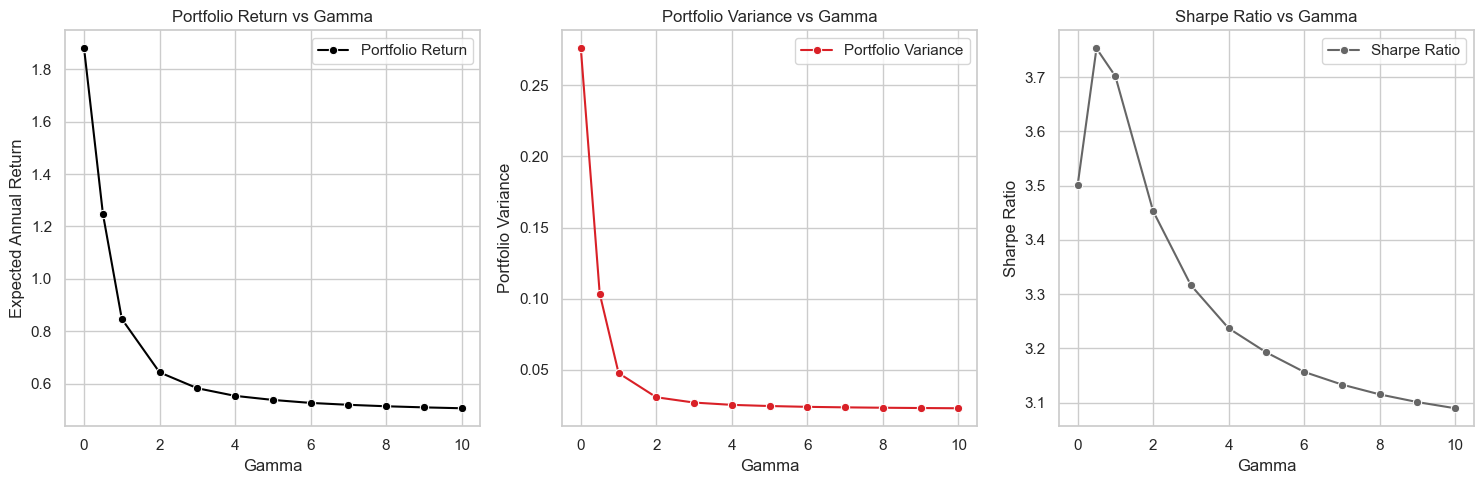

In [76]:
params = {
    'cost': np.full(len(us_market_stocks), 0.001),  # Transaction cost of 0.1% per unit change
    'epsilon': 1e-6,  # Small regularisation. Just to avoid having a 0 in the ln
    'beta': 1.0,  # Weight for utility (note: minimizing, so utility is positive here)
    'delta': 0.1,  # Weight for transaction costs
    'alpha': 0.5,
    'include_semi_variance': False,
}

optimiser.plot_diff_gamma(params)

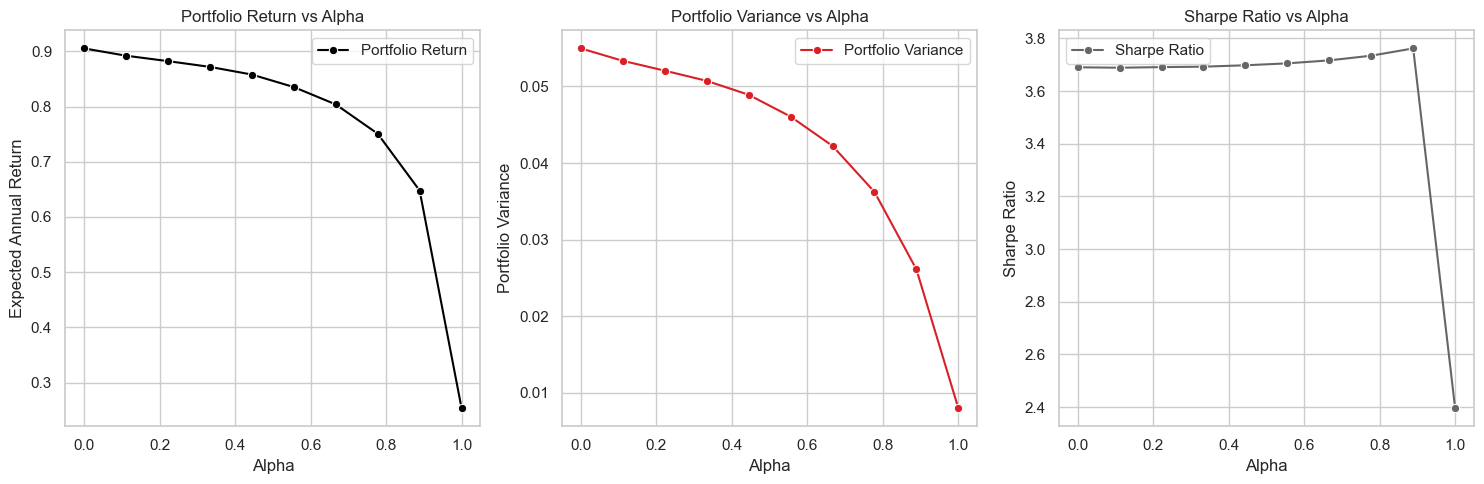

In [77]:
params = {
    'cost': np.full(len(us_market_stocks), 0.001),  # Transaction cost of 0.1% per unit change
    'gamma': 1.0,  # Diversification
    'epsilon': 1e-6,  # Small regularisation. Just to avoid having a 0 in the ln
    'beta': 1.0,  # Weight for utility (note: minimizing, so utility is positive here)
    'delta': 0.1,  # Weight for transaction costs
    'include_semi_variance': False,
}

optimiser.plot_diff_alpha(params)

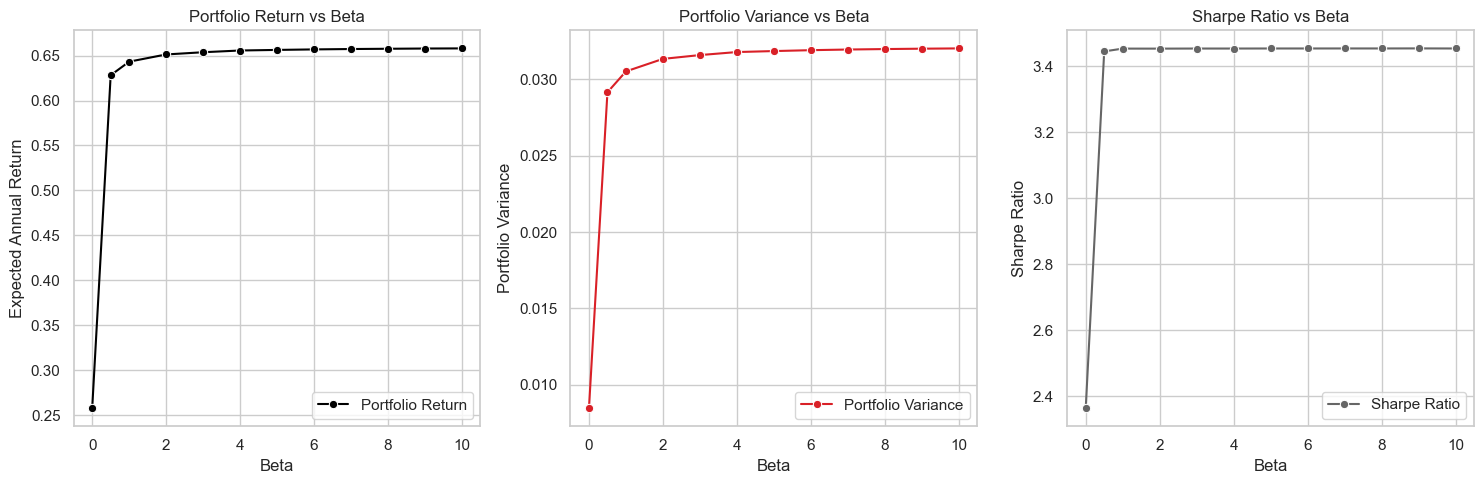

In [78]:
params = {
    'cost': np.full(len(us_market_stocks), 0.001),  # Transaction cost of 0.1% per unit change
    'gamma': 2,  # Diversification
    'epsilon': 1e-6,  # Small regularisation. Just to avoid having a 0 in the ln
    'delta': 0.1,  # Weight for transaction costs
    'alpha': 0.5,
    'include_semi_variance': False,
}

optimiser.plot_diff_beta(params)

## Solve

In [68]:
params = {
    'cost': np.full(len(us_market_stocks), 0.001),  # Transaction cost of 0.1% per unit change
    'gamma': 2.0,  # Diversification
    'epsilon': 1e-6,  # Small regularisation. Just to avoid having a 0 in the ln
    'beta': 2.0,  # Weight for utility (note: minimizing, so utility is positive here)
    'delta': 0.1,  # Weight for transaction costs
    'alpha': 0.5,
    'include_semi_variance': False,
}

w_mvp, _ = optimiser.optimise_mvp(solver = "SLSQP")
w_posterior, _ = optimiser.optimise(params = params, solver = "SLSQP")
w_posterior_noisy = optimiser.noisify_weights(w_posterior)

In [69]:
print("Portfolio Metrics (prior):")
optimiser.display_metrics(*optimiser.compute_metrics(w_prior))

print("Portfolio Metrics (posterior):")
optimiser.display_metrics(*optimiser.compute_metrics(w_posterior))

print("Portfolio Metrics (posterior noisy):")
optimiser.display_metrics(*optimiser.compute_metrics(w_posterior_noisy))

print("Portfolio Metrics (markowitz):")
optimiser.display_metrics(*optimiser.compute_metrics(w_mvp))

Portfolio Metrics (prior):
Expected Annual Return: 0.4771
Portfolio Variance: 0.021448
Sharpe Ratio: 2.9848

Portfolio Metrics (posterior):
Expected Annual Return: 0.6513
Portfolio Variance: 0.031341
Sharpe Ratio: 3.4531

Portfolio Metrics (posterior noisy):
Expected Annual Return: 0.6629
Portfolio Variance: 0.033511
Sharpe Ratio: 3.4028

Portfolio Metrics (markowitz):
Expected Annual Return: 0.2551
Portfolio Variance: 0.007952
Sharpe Ratio: 2.4127



Graph saved to graphs/weight_distributions.png


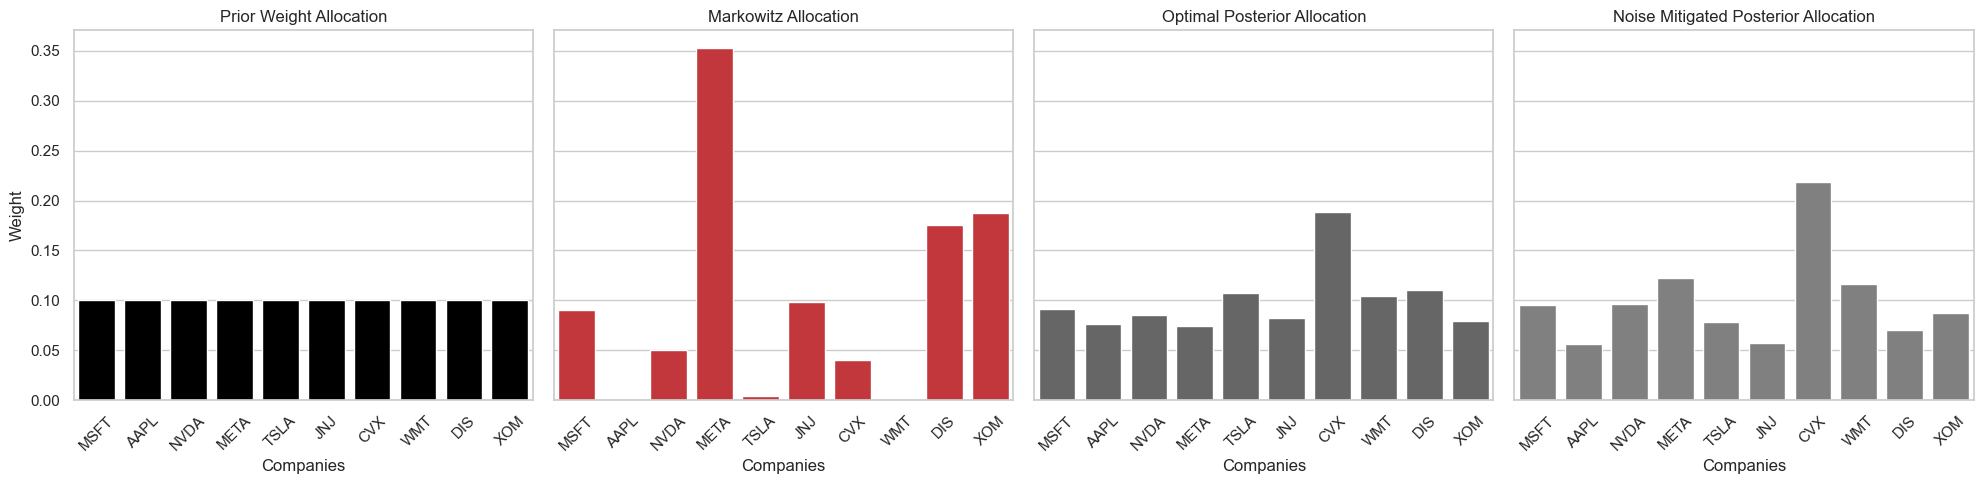

In [70]:
optimiser.display_charts(
    us_market_stocks,
    prior=(w_prior, 'Prior Weight Allocation'),
    basline=(w_mvp, 'Markowitz Allocation'),
    posterior=(w_posterior, 'Optimal Posterior Allocation'),
    noisy=(w_posterior_noisy, 'Noise Mitigated Posterior Allocation'),
)

## Efficient frontier

In [71]:
base_params = {
    'cost': np.full(len(us_market_stocks), 0.001),  # Transaction cost of 0.1% per unit change
    'epsilon': 1e-6,  # Small regularisation
    'beta': 2.0,  # Weight for utility (note: minimizing, so utility is positive here)
    'delta': 0.1,  # Weight for transaction costs
    'include_semi_variance': False,
}

Graph saved to graphs/efficient_frontier_gammas.png


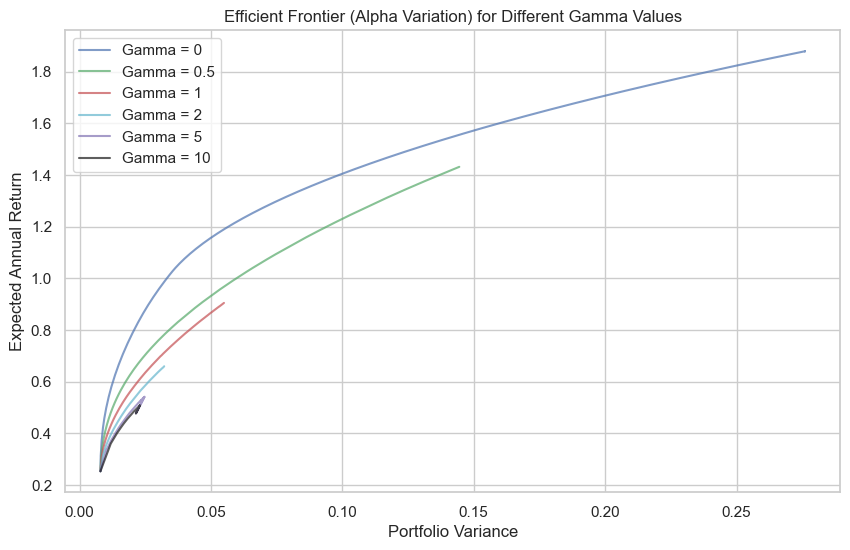

In [72]:
optimiser.efficient_frontier_gammas(method = 'optimiser', base_params = base_params, alpha_range=(0, 1), num_points=500, noisify = False)

/var/folders/xj/kttqfdrn531_xtn6hp0m5r000000gn/T/ipykernel_67270/2445056817.py:381: UserWarning: 
The markers list has fewer values (1) than needed (7) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(data=df, x='Variance', y='Return', hue='Type', style='Type',


Graph saved to graphs/efficient_frontier_noisy_trends.png


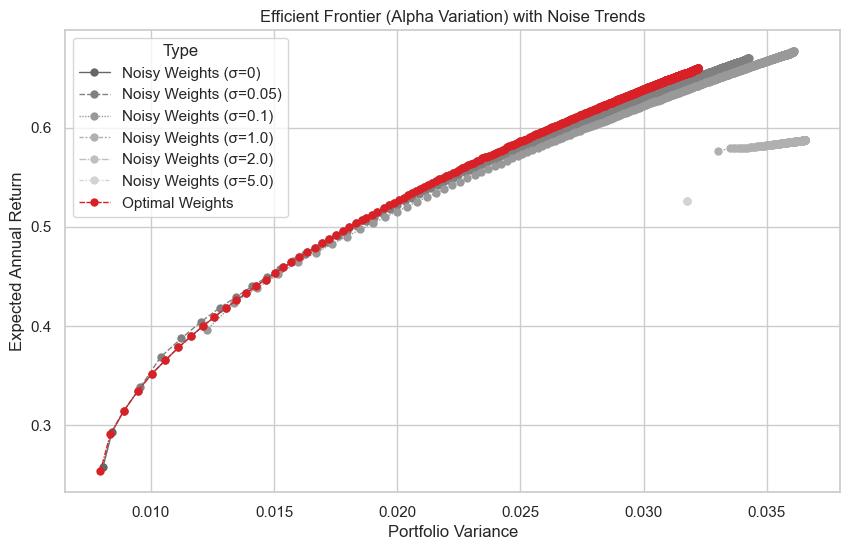

In [73]:
base_params = {
    'cost': np.full(len(us_market_stocks), 0.001),  # Transaction cost of 0.1% per unit change
    'epsilon': 1e-6,  # Small regularisation
    'beta': 2.0,  # Weight for utility (note: minimizing, so utility is positive here)
    'gamma':2.0,
    'delta': 0.1,  # Weight for transaction costs
    'include_semi_variance': False,
}

optimiser.efficient_frontier_noise_trends(base_params = base_params, alpha_range=(0, 1), num_points=1000)

## Benchmark to S&P500

Performance Metrics:
Portfolio Cumulative Return: 61.19%
S&P 500 Cumulative Return: 24.54%
Portfolio Volatility: 17.70%
S&P 500 Volatility: 12.67%
Portfolio Sharpe Ratio: 2.81
S&P 500 Sharpe Ratio: 1.81
Graph saved to graphs/sp500_benchmark_one.png


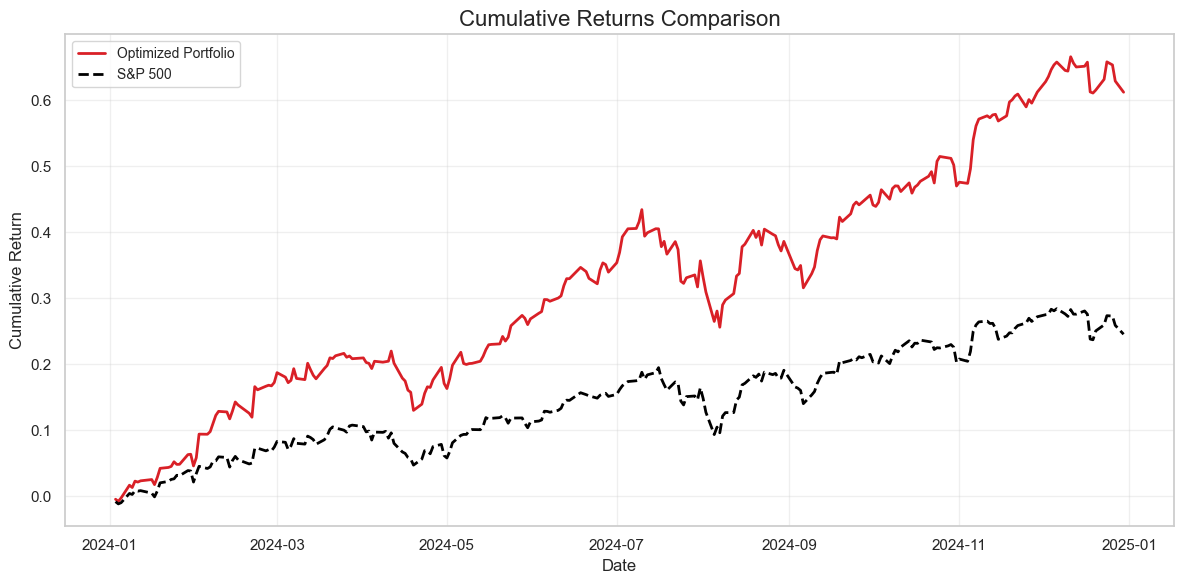

In [79]:
optimiser.benchmark_sp500_one_pf(weights = w_posterior, 
                        portfolio_data = us_data['Close'],
                        sp500_data = sp500_data['Close'].squeeze())

In [83]:
# The business's allocation vector

# Set a random seed for reproducibility (optional)

# Generate 10 random weights between 0 and 1
raw_weights = np.random.random(10)

# Normalize the weights to sum to 1
weights_business = raw_weights / np.sum(raw_weights)
# Round to 4 decimal places for readability
weights_business = np.round(weights_business, 4)
# Print the allocation as a NumPy array
print("Random Business Allocation Vector (Array, weights summing to 1):")
print(weights_business)
# Verify the sum of weights
print(f"\nSum of weights: {np.sum(weights_business):.4f}")

Random Business Allocation Vector (Array, weights summing to 1):
[0.104  0.179  0.0455 0.1172 0.1351 0.0106 0.1385 0.0389 0.0148 0.2163]

Sum of weights: 0.9999


In [84]:
# random weights from a business
weights_business

array([0.104 , 0.179 , 0.0455, 0.1172, 0.1351, 0.0106, 0.1385, 0.0389,
       0.0148, 0.2163])

Performance Metrics:
Optimized Portfolio Cumulative Return: 61.19%
Optimized Portfolio Volatility: 17.63%
Optimized Portfolio Sharpe Ratio: 2.80
---
Equal-weights Portfolio Cumulative Return: 45.25%
Equal-weights Portfolio Volatility: 14.59%
Equal-weights Portfolio Sharpe Ratio: 2.63
---
Randomized Portfolio Cumulative Return: 39.51%
Randomized Portfolio Volatility: 14.05%
Randomized Portfolio Sharpe Ratio: 2.44
---
S&P 500 Cumulative Return: 24.54%
S&P 500 Volatility: 12.62%
S&P 500 Sharpe Ratio: 1.80
---
Graph saved to graphs/sp500_benchmark_all.png


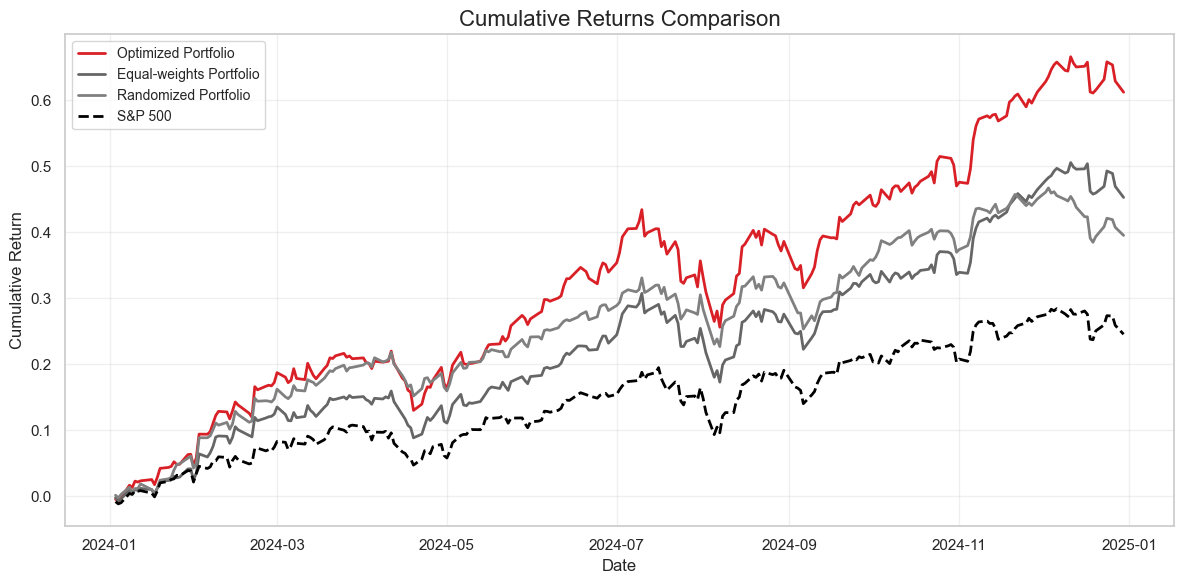

In [85]:
optimiser.benchmark_sp500_multi_pf(weights_list = [w_posterior, w_prior, weights_business], 
                        portfolio_data = us_data['Close'],
                        sp500_data = sp500_data['Close'].squeeze())